In [37]:
import numpy as np
import pandas as pd
import math as e
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

### XGBOOST TREE NODES
A node is a fundamental unit of the regression tree.  
It uses internal gain based on hessain and gradient to calculate the best split.  
A weighted quantile sketch is used to help in creating nodes and leaf values are caclulated based on Loss function.  

Inputs:  

------------------------------------
- x: Training Dataframe.
- gradient: gradient of the loss function.
- hessian: second order derivative of the loss function.
- idxs: used to keep track of samples within the tree structure.
- subsample_cols: controls the subsampling of columns (features) during each boosting iteration.
- min_leaf: minimum number of samples for a node to be considered a node.
- min_child_weight: sum of the heassian inside a node is a meaure of purity.
- depth: limits the height of a tree to prevent overfitting.
- lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
- gamma: Used for pruning. This parameter also prevents over fitting and is present in the the calculation of the gain (structure-score). As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node. 
- eps: This parameter is used in the quantile weighted sketch.
------------------------------------

Output: Tree Object.

In [38]:
class Node:
    def __init__(self,x,gradient,hessian,idxs,subsample_cols = 1, min_leaf = 1, min_child_weight = 1, 
                 depth = 2, lambda_ = 1, gamma = 1, eps = 0.1):
        self.x = x
        self.gradient = gradient
        self.hessian = hessian
        self.idxs = idxs
        self.subsample_cols = subsample_cols
        self.min_leaf = min_leaf
        self.min_child_weight = min_child_weight
        self.depth = depth
        self.lambda_ = lambda_
        self.gamma = gamma
        self.eps = eps
        self.rows_cnt = len(idxs)
        self.col_count = x.shape[1]
        
        # print(gradient[self.idxs])
        # Select a subspace of attributes.
        self.column_subsample = np.random.permutation(self.col_count)[:round(self.subsample_cols*self.col_count)]
        
        self.val = self.calc_val(self.gradient[self.idxs],self.hessian[self.idxs])
        
        self.score = float('-inf')
        self.find_split()
        # print(self.is_leaf)
        
    def calc_val(self,gradient,hessian):
        # Calculate the optimal value of a leaf.
        value = np.sum(gradient)/(np.sum(hessian)+self.lambda_)
        value = value*-1
        return value

    def find_split(self):
        # Scans through every column & calculates the best split point. If node is split, 
        # two other nodes are created accordingly. If no split is better then we just return 
        # without making splits.
        
        for col in self.column_subsample:
            self.find_greedy_split(col)
        
        # print(self.score)
        
        if (self.is_leaf()):
            # print("I am Leaf")
            # print(str(self.score) + " " +str(self.depth))
            return
        
        # print("----------------Hello----------------")
        
        # print(self.split)
        
        split_col = self.split_col()
        
        lhs = np.nonzero(split_col <= self.split)[0]
        rhs = np.nonzero(split_col > self.split)[0]
        
        # print(lhs)
        # print(rhs)
        
        # print("----------------Bye------------------")
        
        self.lhs = Node(x = self.x, gradient= self.gradient, hessian = self.hessian, idxs = self.idxs[lhs],
                        min_leaf= self.min_leaf, depth = self.depth - 1, lambda_= self.lambda_, 
                        min_child_weight = self.min_child_weight, eps = self.eps, 
                        subsample_cols = self.subsample_cols)
        
        self.rhs = Node(x = self.x, gradient= self.gradient, hessian = self.hessian, idxs = self.idxs[rhs],
                        min_leaf= self.min_leaf, depth = self.depth - 1, lambda_= self.lambda_, 
                        min_child_weight = self.min_child_weight, eps = self.eps, 
                        subsample_cols = self.subsample_cols)
    
    def find_greedy_split(self,col):
        # For the given attribute 'col' we try to calculate the best possible split.
        # Globally updates the best score and split point if a better split point is found.
        
        x = self.x.values[self.idxs, col]   # returns numpy array of values of 'col' at certain indices
        
        for r in range(0,self.rows_cnt):
            # print(x[r])
            lhs = x <= x[r]
            rhs = x > x[r]
            
            lhs_indices = np.nonzero(x <= x[r])[0]            
            rhs_indices = np.nonzero(x > x[r])[0]   
            
            # print(lhs_indices) 
            # print(lhs_indices) 
            
            if(len(lhs_indices) < self.min_leaf or len(rhs_indices) < self.min_leaf or
               self.hessian[lhs_indices].sum() < self.min_child_weight or 
               self.hessian[rhs_indices].sum() < self.min_child_weight):
                continue
            
            poss_score = self.gain(lhs_indices,rhs_indices)
            
            if poss_score > self.score:
                # print(col)
                self.col = col
                self.score = poss_score
                self.split = x[r]
                
    def gain(self,lhs,rhs):
        # Calculates the gain for a particular split.
        gradient = self.gradient[self.idxs]        
        hessian = self.hessian[self.idxs]        
        
        lhs_gradient = gradient[lhs].sum()
        lhs_hessian = hessian[lhs].sum()
        
        rhs_gradient = gradient[rhs].sum()
        rhs_hessian = hessian[rhs].sum()
        
        gain = 0.5*((lhs_gradient**2)/(lhs_hessian+self.lambda_) + (rhs_gradient**2)/(rhs_hessian+self.lambda_)-
                    ((gradient.sum())**2)/(hessian.sum()+self.lambda_)) - self.gamma
        
        return gain
    
    def split_col(self):    # Return values of a particular column
        return self.x.values[self.idxs, self.col]
    
    def is_leaf(self):      # Check if node is leaf or not
        # print(str(self.score) + " " +str(self.depth))
        return self.score == float('-inf') or self.depth <=0 or len(self.x) == 1
    
    def predict(self,x):
        return np.array([self.predict_val(xi) for xi in x])
    
    def predict_val(self,xi):
        # print(xi)
        if (self.is_leaf()):
            return self.val
        
        node = self.lhs if xi[self.col] <= self.split else self.rhs
        
        return node.predict_val(xi)
    
    
    

### XGBOOST TREE
The XGBoost tree is a regression tree, which builds the regression tree from pseudo residuals/ previous predictions to make better estimates.  

Inputs:  

------------------------------------
- x: Training Dataframe.
- gradient: gradient of the loss function.
- hessian: second order derivative of the loss function.
- idxs: used to keep track of samples within the tree structure.
- subsample_cols: controls the subsampling of columns (features) during each boosting iteration.
- min_leaf: minimum number of samples for a node to be considered a node.
- min_child_weight: sum of the heassian inside a node is a meaure of purity.
- depth: limits the height of a tree to prevent overfitting.
- lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
- gamma: Used for pruning. This parameter also prevents over fitting and is present in the the calculation of the gain (structure-score). As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node. 
- eps: This parameter is used in the quantile weighted sketch.
------------------------------------

Output: Root of the Regression tree.

In [39]:
class XGBoostTree:
    def fit(self,x,gradient,hessian,subsample_cols = 1, min_leaf = 1, min_child_weight = 1, 
            depth = 7, lambda_ = 1, gamma = 1, eps = 0.1):
        self.root = Node(x, gradient, hessian, np.array(np.arange(len(x))), subsample_cols, min_leaf, min_child_weight,
                         depth, lambda_, gamma, eps)
    def predict(self,X):
        return self.root.predict(X.values)

### XGBOOST Regression Model
This is the full application of the XGBoost Algorithm to create and fit the model on a dataset to make further predictions. 

Inputs:  

------------------------------------
- x: Training Dataframe.
- gradient: gradient of the loss function.
- hessian: second order derivative of the loss function.
- idxs: used to keep track of samples within the tree structure.
- subsample_cols: controls the subsampling of columns (features) during each boosting iteration.
- min_leaf: minimum number of samples for a node to be considered a node.
- min_child_weight: sum of the heassian inside a node is a meaure of purity.
- depth: limits the height of a tree to prevent overfitting.
- lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
- gamma: Used for pruning. This parameter also prevents over fitting and is present in the the calculation of the gain (structure-score). As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node. 
- eps: This parameter is used in the quantile weighted sketch.
------------------------------------

Output: Object used for gradient boosting.

In [40]:
class XGBoostRegression:
    
    def __init__(self):
        self.trees = []
    
    def gradient(self,prediction, actual):
        return (2*(prediction-actual))
    
    def hessian(self,prediction, actual):
        return (np.full((prediction.shape[0],),2).astype('float'))
    
    def fit(self, X, Y, subsample_cols = 1, min_leaf = 1, min_child_weight = 1, 
            depth = 5, lambda_ = 1, gamma = 1, eps = 0.1, learning_rate = 0.4, boosting_rounds = 5):
        self.X = X
        self.Y = Y
        self.subsample_cols = subsample_cols
        self.min_leaf = min_leaf
        self.min_child_weight = min_child_weight
        self.depth = depth
        self.lambda_ = lambda_
        self.gamma = gamma
        self.eps = eps
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds
        
        self.prediction = np.full((X.shape[0],1),np.mean(Y)).flatten().astype('float')
        
        # print(self.prediction)
        
        for booster in range(0,self.boosting_rounds):
            Gradient = self.gradient(np.array(self.prediction), np.array(self.Y))
            Hessian = self.hessian(np.array(self.prediction), np.array(self.Y))
            
            # print(Gradient)
            # print(Hessian)
            
            boosting_tree = XGBoostTree()
            boosting_tree.fit(  self.X, Gradient,Hessian, self.subsample_cols, self.min_leaf,
                                self.min_child_weight,self.depth,self.lambda_, self.gamma,
                                self.eps)
            self.prediction = self.prediction + learning_rate*(boosting_tree.predict(self.X))
            self.trees.append(boosting_tree)
            print("Iteration: "+ str(booster) + "RMSE Score = " +str(np.sqrt(np.mean((self.predict(self.X) - self.Y)**2))))
    
    def predict(self,X):
        
        pred = np.zeros(X.shape[0])
        
        for tree in self.trees:
            pred += self.learning_rate*(tree.predict(X))
        
        # print(pred)
        
        return np.full((X.shape[0],),np.mean(self.Y)).astype('float') + pred

In [41]:
data = {'Dosage':[10,20,25,37],
        'Level' : [10,20,25,37]}
df = pd.DataFrame(data)

test_data = {'Dosage':[10,20,25,37],
             'Level' : [10,20,25,37]}
test_df = pd.DataFrame(test_data)

Y = [-10,7,8,-7]

In [42]:
model = XGBoostRegression()
model.fit(df,Y,boosting_rounds = 9,gamma = 0)

Iteration: 0RMSE Score = 5.923681287847955
Iteration: 1RMSE Score = 4.344032944421833
Iteration: 2RMSE Score = 3.185624159242677
Iteration: 3RMSE Score = 2.33612438344463
Iteration: 4RMSE Score = 1.7131578811927288
Iteration: 5RMSE Score = 1.2563157795413342
Iteration: 6RMSE Score = 0.921298238330312
Iteration: 7RMSE Score = 0.6756187081088957
Iteration: 8RMSE Score = 0.4954537192798568


In [43]:
model.predict(test_df)

array([-9.41731151,  6.53998277,  7.47864714, -6.6013184 ])

In [44]:
print(np.sqrt(np.mean((model.predict(test_df) - Y)**2)))

0.4954537192798568


In [45]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)

In [46]:
new_df.columns

Index(['Datetime', 'PJME_MW', 'Lag1', 'Lag2', 'Hour_sin', 'Hour_cos',
       'Day_sin', 'Day_cos'],
      dtype='object')

In [47]:
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']

In [48]:
X

,Lag1,Lag2,Hour_sin,Hour_cos,Day_sin,Day_cos
0,27077.0,25591.0,0.258819,0.965926,-2.449294e-16,1.000000
1,25957.0,24235.0,0.500000,0.866025,-2.449294e-16,1.000000
2,24930.0,23121.0,0.707107,0.707107,-2.449294e-16,1.000000
3,24359.0,22445.0,0.866025,0.500000,-2.449294e-16,1.000000
4,24400.0,22332.0,0.965926,0.258819,-2.449294e-16,1.000000
...,...,...,...,...,...,...
127745,31448.0,32878.0,-0.866025,0.500000,1.716633e-02,0.999853
127746,31246.0,32586.0,-0.707107,0.707107,1.716633e-02,0.999853
127747,30526.0,31877.0,-0.500000,0.866025,1.716633e-02,0.999853
127748,29209.0,30590.0,-0.258819,0.965926,1.716633e-02,0.999853


In [49]:
Y

0         27160.0
1         25791.0
2         25052.0
3         24797.0
4         25026.0
           ...   
127745    44284.0
127746    43751.0
127747    42402.0
127748    40164.0
127749    38608.0
Name: PJME_MW, Length: 127750, dtype: float64

In [50]:
model = XGBoostRegression()
model.fit(X,Y,min_leaf = 5,min_child_weight = 5,boosting_rounds = 6)

Iteration: 0RMSE Score = 5098.168820440851
Iteration: 1RMSE Score = 4436.737263346453
Iteration: 2RMSE Score = 4134.129389221016
Iteration: 3RMSE Score = 3963.7051196392435
Iteration: 4RMSE Score = 3864.8495513345297
Iteration: 5RMSE Score = 3822.3960831632016


In [51]:
print(np.mean((model.predict(X) - Y)**2))

14610711.816581385


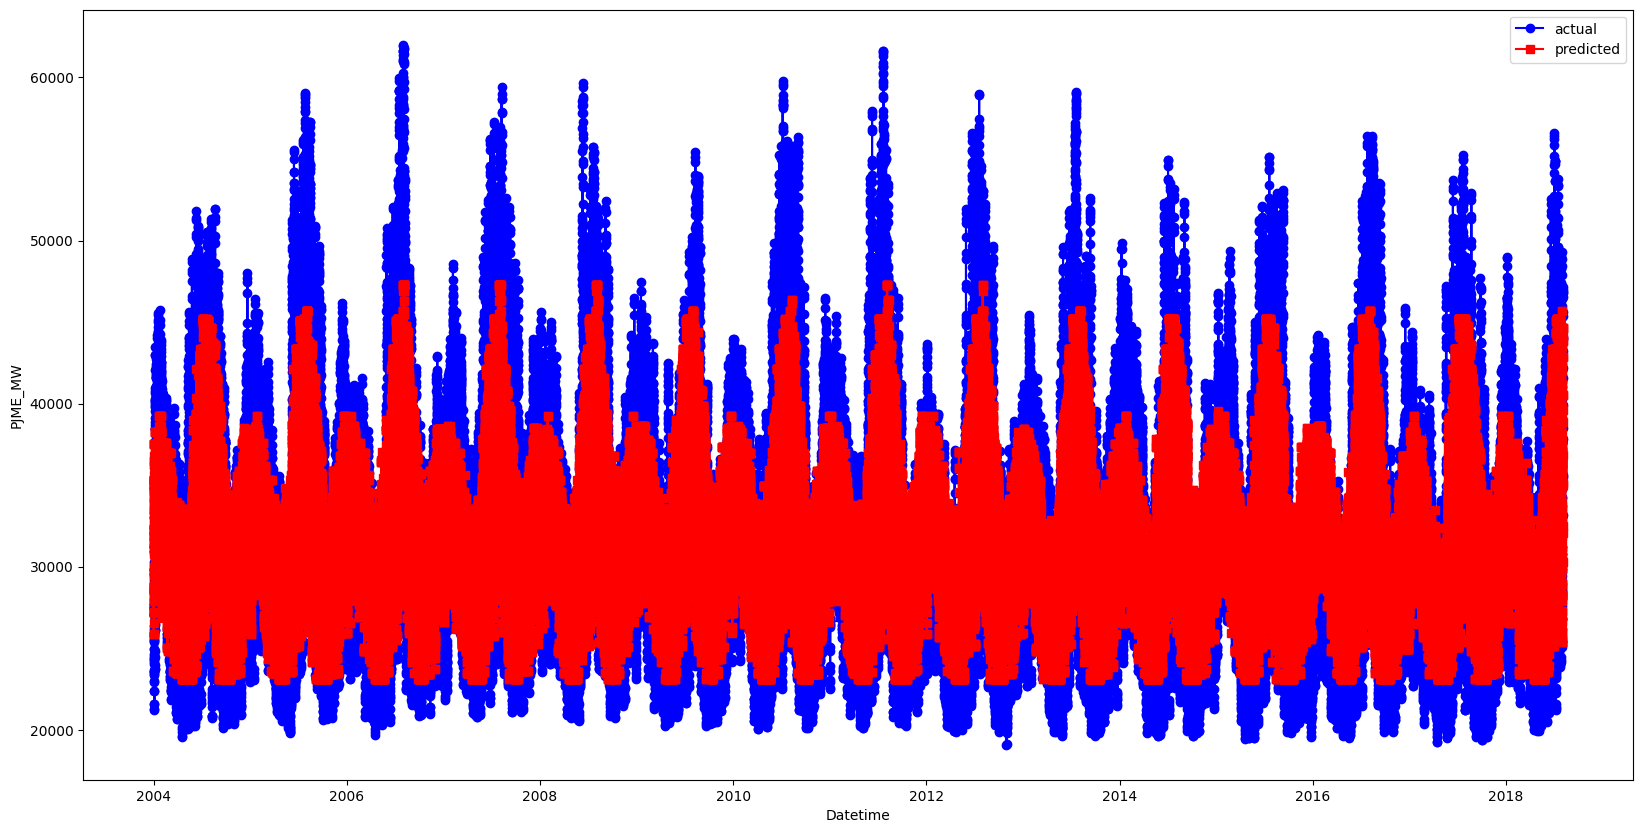

In [52]:
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')

plt.plot(new_df['Datetime'], model.predict(X), label='predicted',color='red', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.legend()
plt.show()